In [1]:
import sys
%matplotlib inline
from matplotlib import pyplot as plt
import os
from keras_text.data import Dataset
from keras_text.processing import WordTokenizer, pad_sequences


imdb_ds = 'datasets/aclImdb.ds'
try:
    ds = Dataset.load(imdb_ds)
    tokenizer = ds.tokenizer
except FileNotFoundError:
    imdb_dir = 'data/aclImdb'
    if not os.path.exists(imdb_dir):
        print('Donload data from http://mng.bz/0tIo and uncompress it in '
              '`data` directory.')
        sys.exit(1)
    train_dir = os.path.join(imdb_dir, 'train')
    texts, labels = [], []
    for label_type in ['neg', 'pos']:
        print(label_type)
        dir_name = os.path.join(train_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                f = open(os.path.join(dir_name, fname))
                texts.append(f.read())
                f.close()
                labels.append(label_type)

    tokenizer = WordTokenizer(lang='en_core_web_sm')
    tokenizer.build_vocab(texts)
    sequences = tokenizer.encode_texts(texts)
    data = pad_sequences(sequences, max_tokens=500)
    ds = Dataset(data, labels, tokenizer=tokenizer)
    os.makedirs(os.path.dirname(imdb_ds), exist_ok=True)
    ds.save(imdb_ds)
    

Using TensorFlow backend.


In [2]:
X_train, X_val, y_train, y_val = ds.train_val_split(0.5)
print(f'Num classes: {ds.num_classes}')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val  : {X_val.shape}')
print(f'X_val  : {y_val.shape}')


Num classes: 1
X_train: (12500, 500)
y_train: (12500,)
X_val  : (12500, 500)
X_val  : (12500,)


In [4]:
from keras_text.models.token_model import TokenModelFactory
from keras_text.models.sequence_encoders import YoonKimCNN

# RNN models can use `max_tokens=None` to indicate variable length words per mini-batch.
factory = TokenModelFactory(
    ds.num_classes, 
    tokenizer.token_index,
    max_tokens=None,
    embedding_type='glove.6B.100d')
word_encoder_model = YoonKimCNN()
model = factory.build_model(
    token_encoder_model=word_encoder_model, output_activation='sigmoid')
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


INFO:keras_text.embeddings:Building embeddings index...
INFO:keras_text.embeddings:Loading embeddings for all words in the corpus


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         10136200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         60400     
_________________________________________________________________
attention_layer_1 (Attention (None, 100)               10200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,206,901
Trainable params: 10,206,901
Non-trainable params: 0
________________________________________________________________

In [ ]:
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Train on 12500 samples, validate on 12500 samples
Epoch 1/20
  288/12500 [..............................] - ETA: 12:05 - loss: 0.6935 - acc: 0.5139

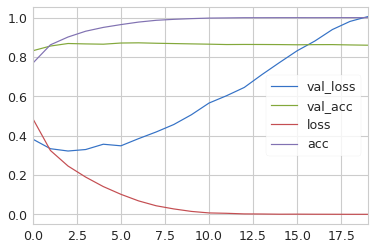

In [5]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist.plot()
plt.show()